In [ ]:
!pip install geopandas
!pip install tensorflow
!pip install scikit-optimize
import geopandas as gpd
import numpy as np
from sklearn.model_selection import train_test_split

# Load geospatial data
import geopandas as gpd

url = "https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip"

gdf = gpd.read_file(url)

# Use the geometry's centroid coordinates as features
gdf['x'] = gdf.centroid.x
gdf['y'] = gdf.centroid.y

# Generate binary labels based on some criteria
gdf['label'] = (gdf['POP_EST'] > 1e7).astype(int)

# Prepare features and labels
features = gdf[['x', 'y']].values
labels = gdf['label'].values

# Split data into training and testing
x_train, x_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

<ipython-input-16-8600a2be7f79>:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['x'] = gdf.centroid.x
<ipython-input-16-8600a2be7f79>:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf['y'] = gdf.centroid.y


In [ ]:

from skopt import gp_minimize
from skopt.space import Real, Integer
from skopt.utils import use_named_args
import tensorflow as tf # Import TensorFlow
import numpy as np
from tensorflow.keras.layers import Dropout

# Define the search space
space = [
    Real(1e-5, 1e-1, name='learning_rate', prior='log-uniform'),
    Integer(10, 100, name='batch_size'),
    Real(0.0, 1.0, name='alpha')
]

# Placeholder for soft labels - replace this with your actual soft label generation logic
# Example: Generate random soft labels for demonstration
# Assuming x_train and y_train are defined elsewhere
# Replace this with your actual data
#x_train = np.random.rand(100,2) # Commented out as x_train is already defined from the previous cell
#y_train = np.random.randint(0,2,100) # Commented out as y_train is already defined from the previous cell
#x_test = np.random.rand(20,2) # Commented out as x_test is already defined from the previous cell
#y_test = np.random.randint(0,2,20) # Commented out as y_test is already defined from the previous cell

soft_labels = np.random.rand(len(x_train))

# Define the objective function
@use_named_args(space)
def objective(**params):
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    alpha = params['alpha']

    student_model = tf.keras.models.Sequential([ # Use tf.keras.models
        tf.keras.layers.Dense(64, activation='relu', input_shape=(2,),kernel_regularizer=tf.keras.regularizers.l2(0.01)), # Add L2 regularization to the Dense layer
        Dropout(0.2),
        tf.keras.layers.Dense(1)
    ])

    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    student_model.compile(optimizer=optimizer)

    beta = 0.01
    num_epochs = 10
    batch_size = int(batch_size)
    num_batches = len(x_train) // batch_size

    for epoch in range(num_epochs):
        for i in range(num_batches):
            batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
            x_batch, y_batch, y_soft_batch = x_train[batch_indices], y_train[batch_indices], soft_labels[batch_indices]

            with tf.GradientTape() as tape:
                logits = student_model(x_batch, training=True)
                y_batch = tf.reshape(y_batch, (-1, 1))
                y_soft_batch = tf.reshape(y_soft_batch, (-1, 1))
                loss_true = tf.keras.losses.binary_crossentropy(y_batch, logits, from_logits=True)
                loss_soft = tf.keras.losses.binary_crossentropy(y_soft_batch, logits, from_logits=True)
                regularization_loss = tf.add_n(student_model.losses) # Now this should work as the model has regularization losses
                loss = alpha * loss_true + (1 - alpha) * loss_soft + beta * regularization_loss

            grads = tape.gradient(loss, student_model.trainable_variables)
            student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

    student_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    loss, accuracy = student_model.evaluate(x_test, y_test, verbose=0)
    return loss

# Run Bayesian Optimization with Surrogate Model
res = gp_minimize(objective, space, n_calls=50, random_state=42)
best_params = res.x
print(f"Best Parameters: {best_params}")

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/lo

Best Parameters: [0.04010874778601555, 10, 0.7792493679587126]


In [ ]:
# Define the student model with optimized hyperparameters
# Unpack the best parameters from the result object
best_learning_rate, best_batch_size, best_alpha = res.x

student_model = tf.keras.models.Sequential([  # Use tf.keras.models
    tf.keras.layers.Dense(64, activation='relu', input_shape=(2,), kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.2),
    tf.keras.layers.Dense(1)
])

optimizer = tf.keras.optimizers.Adam(learning_rate=best_learning_rate)
student_model.compile(optimizer=optimizer)

# Custom training loop with optimized hyperparameters
beta = 0.01  # Regularization term
num_epochs = 20
# Ensure batch size is at least 1 to avoid ZeroDivisionError
batch_size = max(1, int(best_batch_size))  # Modified line
num_batches = len(x_train) // batch_size

# Placeholder for training a teacher model - you'll need to implement this function
def train_teacher_model(x_train, y_train):
    # TODO: Implement logic to train your teacher model here
    # This is just a placeholder, replace it with your actual model and training logic
    model = tf.keras.models.Sequential([
        tf.keras.layers.Dense(128, activation='relu', input_shape=(2,)),
        Dropout(0.2),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer='adam', loss='binary_crossentropy')
    model.fit(x_train, y_train, epochs=10)  # Adjust epochs as needed
    return model

# Train the teacher model outside the loop to get soft labels
teacher_model = train_teacher_model(x_train, y_train)
soft_labels = teacher_model.predict(x_train, verbose=0)

for epoch in range(num_epochs):
    for i in range(num_batches):
        batch_indices = np.random.choice(len(x_train), size=batch_size, replace=False)
        x_batch, y_batch, y_soft_batch = x_train[batch_indices], y_train[batch_indices], soft_labels[batch_indices]

        with tf.GradientTape() as tape:
            logits = student_model(x_batch, training=True)
            y_batch = tf.reshape(y_batch, (-1, 1))
            y_soft_batch = tf.reshape(y_soft_batch, (-1, 1))
            loss_true = tf.keras.losses.binary_crossentropy(y_batch, logits, from_logits=True)
            loss_soft = tf.keras.losses.binary_crossentropy(y_soft_batch, logits, from_logits=True)
            regularization_loss = tf.add_n(student_model.losses)
            loss = best_alpha * loss_true + (1 - best_alpha) * loss_soft + beta * regularization_loss

        grads = tape.gradient(loss, student_model.trainable_variables)
        student_model.optimizer.apply_gradients(zip(grads, student_model.trainable_variables))

    print(f"Epoch {epoch + 1}, Loss: {tf.reduce_mean(loss).numpy()}")

# Evaluate the student model
student_model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
student_model.evaluate(x_test, y_test)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 3.5110
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - loss: 2.6517
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 3.3243 
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 2.0539 
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - loss: 2.5779
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 1.7994
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 1.7899
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 2.0928
Epoch 9/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - loss: 1.8805 
Epoch 10/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - loss: 2.0371 
Epoch 1, Loss: 1.1769074201583862
Epoch 2, Loss: 1.0177440643310547
Epoch 3, Loss: 1.3352348804473877
Epoch 4, Loss: 0.7756938934326172
Epoch 5, Loss: 0.8394039273262024
Epoch 6, Loss: 0.6403219103813171
Epoch 7, Loss: 0.5922806859016418
Epoch 8, Loss: 0.7034880518913269
Epoch 9, Loss: 0.6357801556587219
Epoch 10, Loss: 0.6569957137107849
Epoch 11, Loss: 1.0211679

[3.402470350265503, 0.5]

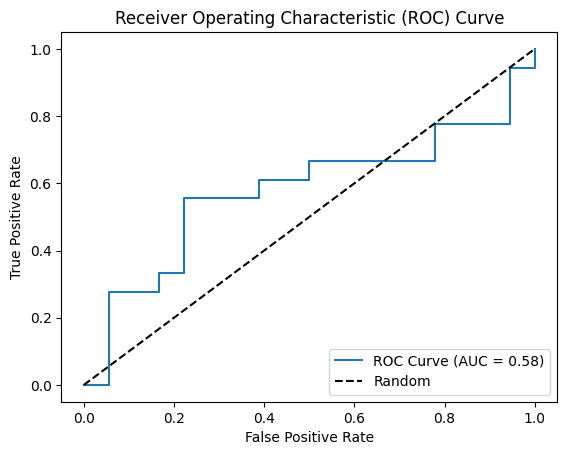

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_pred_probs = tf.sigmoid(student_model(x_test)).numpy().flatten()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
auc_score = roc_auc_score(y_test, y_pred_probs)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {auc_score:.2f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random') # Diagonal line for random classifier
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()


In [ ]:
auc_score

0.5771604938271604